In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

from neuropacks import ECOG
from uoineuro.utils import plot_metric_summary

%matplotlib inline

In [3]:
data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')

In [2]:
data_path = '/storage/data/ecog/r32_b7.mat'
grid_path = '/storage/data/ecog/grdid.mat'

In [3]:
fits_path = os.path.join(os.environ['HOME'],
                         'fits/uoineuro/tuning/ecog/ecog_tuning.h5')

In [4]:
ecog = ECOG(data_path=data_path, grid_path=grid_path)
fits = h5py.File(fits_path, 'r')

# Metric Comparison

In [5]:
baseline = fits['lasso']
algorithms = [fits['uoi_lasso_r2'], fits['uoi_lasso_aic'], fits['uoi_lasso_bic']]

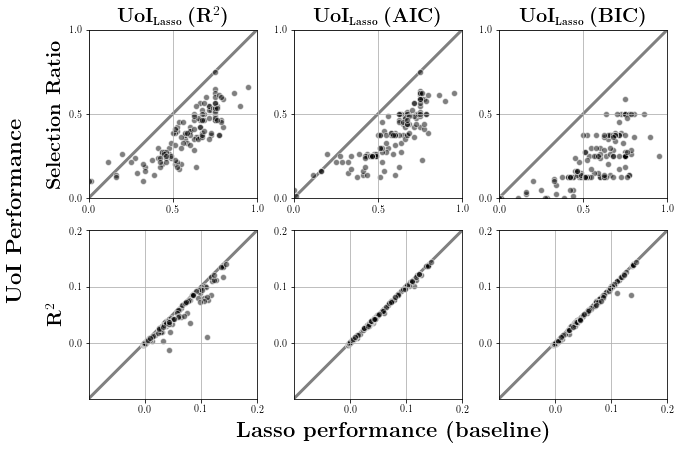

In [14]:
fig, axes = plot_metric_summary(baseline_group=baseline,
                                fits_groups=algorithms,
                                metrics=['selection_ratio', 'r2'])

# additional customizations

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([-0.1, 0.2])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0.0, 0.1, 0.2])
    ax.set_yticks([0.0, 0.1, 0.2])
    ax.grid('on')

for ax in axes.ravel():
    ax.tick_params(labelsize=10)
        
axes[0, 0].set_ylabel(r'\textbf{Selection Ratio}', fontsize=20)
axes[1, 0].set_ylabel(r'$\mathbf{R}^2$', fontsize=20)

axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(BIC)}',
                     fontsize=20)
fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{Lasso performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.03, y=0.5,
    s=r'\textbf{UoI Performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')
    
plt.tight_layout()
#plt.savefig('ecog_tuning_metric_summary.pdf', bbox_inches='tight')

# Grid of Tuning Curves

In [7]:
lasso_coefs = np.mean(fits['lasso/tuning_coefs'], axis=0)
lasso_intercepts = np.mean(fits['lasso/intercepts'], axis=0)

uoi_r2_coefs = np.mean(fits['uoi_lasso_r2/tuning_coefs'], axis=0)
uoi_r2_intercepts = np.mean(fits['uoi_lasso_r2/intercepts'], axis=0)

uoi_aic_coefs = np.mean(fits['uoi_lasso_aic/tuning_coefs'], axis=0)
uoi_aic_intercepts = np.mean(fits['uoi_lasso_aic/intercepts'], axis=0)

uoi_bic_coefs = np.mean(fits['uoi_lasso_bic/tuning_coefs'], axis=0)
uoi_bic_intercepts = np.mean(fits['uoi_lasso_bic/intercepts'], axis=0)

In [19]:
dead_electrodes = [19, 21, 0]

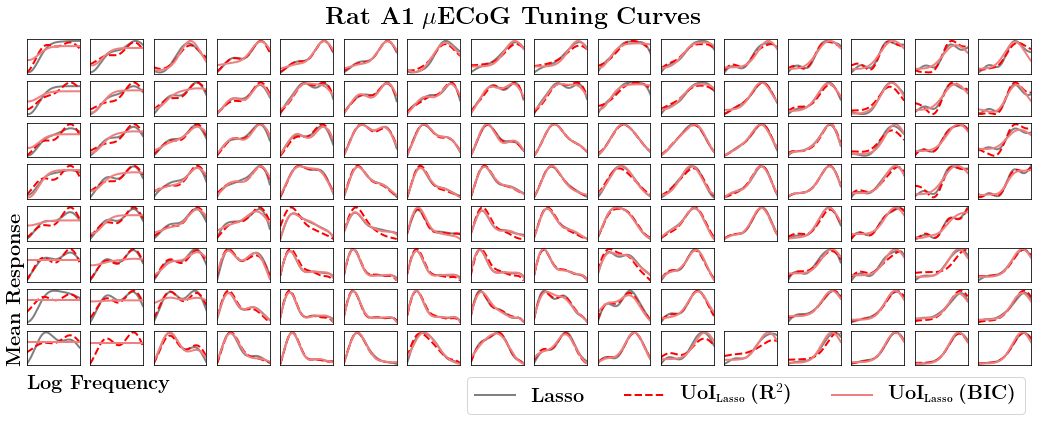

In [20]:
fig, axes = plt.subplots(8, 16, figsize=(18, 6))

for electrode in range(ecog.n_electrodes):
    x, y = ecog.get_xy_for_electrode(electrode)
    ax = axes[x, y]
    
    if electrode in dead_electrodes:
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    frequencies, lasso_tc = ecog.get_tuning_curve(tuning_coefs=lasso_coefs[electrode], )
    _, uoi_r2_tc = ecog.get_tuning_curve(tuning_coefs=uoi_r2_coefs[electrode])
    _, uoi_aic_tc = ecog.get_tuning_curve(tuning_coefs=uoi_aic_coefs[electrode])
    _, uoi_bic_tc = ecog.get_tuning_curve(tuning_coefs=uoi_bic_coefs[electrode])
    
    ax.plot(
        frequencies, lasso_intercepts[electrode] + lasso_tc,
        color='gray',
        linewidth=2,
        alpha=1,
        zorder=-1,
        label=r'\textbf{Lasso}')

    ax.plot(
        frequencies, uoi_r2_intercepts[electrode] + uoi_r2_tc,
        color='red',
        linewidth=2,
        linestyle='--',
        alpha=1,
        label=r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}')

    axes[x, y].plot(
         frequencies, uoi_bic_intercepts[electrode] + uoi_bic_tc,
         color='lightcoral',
         linewidth=2,
         alpha=1,
         label=r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(BIC)}')

    ax.set_xscale('log')
    ax.set_xlim([frequencies[0], frequencies[-1]])
    ax.set_xticks([])
    ax.set_yticks([])

fig.text(
    x=0.125, y=0.08,
    s=r'\textbf{Log Frequency}',
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=20)

fig.text(
    x=0.11, y=0.3,
    s=r'\textbf{Mean Response}',
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=20,
    rotation=90)

fig.text(
    x=0.50, y=0.93,
    s=r'\textbf{Rat A1} $\mu$\textbf{ECoG Tuning Curves}',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=25)

axes[0, 0].legend(
    loc='lower center',
    bbox_transform=fig.transFigure,
    bbox_to_anchor=(0.68, -0.01),
    ncol=3,
    fancybox=True,
    prop={'size': 20})

plt.tight_layout()
#plt.savefig('ecog_tuning_curve_grid.pdf', bbox_inches='tight')

# Tonotopy Maps

In [21]:
pref_frequency_lasso = np.zeros((8, 16))
pref_frequency_uoi_r2 = np.zeros((8, 16))
pref_frequency_uoi_aic = np.zeros((8, 16))
pref_frequency_uoi_bic = np.zeros((8, 16))
pref_frequencies = [pref_frequency_lasso,
                    pref_frequency_uoi_r2,
                    pref_frequency_uoi_aic,
                    pref_frequency_uoi_bic]

In [22]:
for electrode in range(ecog.n_electrodes):
    x, y = ecog.get_xy_for_electrode(electrode)

    if electrode not in dead_electrodes:        
        frequencies, lasso_tc = ecog.get_tuning_curve(tuning_coefs=lasso_coefs[electrode])
        _, uoi_r2_tc = ecog.get_tuning_curve(tuning_coefs=uoi_r2_coefs[electrode])
        _, uoi_aic_tc = ecog.get_tuning_curve(tuning_coefs=uoi_aic_coefs[electrode])
        _, uoi_bic_tc = ecog.get_tuning_curve(tuning_coefs=uoi_bic_coefs[electrode])

        pref_frequency_lasso[x, y] = frequencies[np.argmax(lasso_tc)]
        pref_frequency_uoi_r2[x, y] = frequencies[np.argmax(uoi_r2_tc)]
        pref_frequency_uoi_aic[x, y] = frequencies[np.argmax(uoi_aic_tc)]
        pref_frequency_uoi_bic[x, y] = frequencies[np.argmax(uoi_bic_tc)]

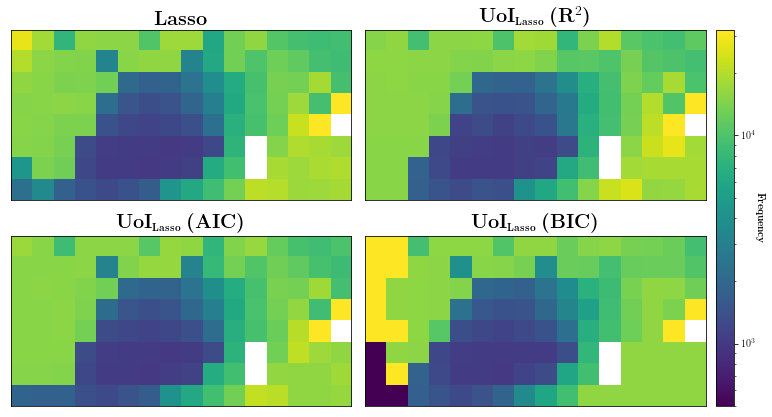

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for idx, ax in enumerate(axes.ravel()):
    img = ax.imshow(pref_frequencies[idx],
                    cmap='viridis',
                    vmin=ecog.freq_set[0],
                    vmax=ecog.freq_set[-1],
                    norm=matplotlib.colors.LogNorm(),
                    origin='upper')
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[0, 0].set_title(r'\textbf{Lasso}', fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}',
                     fontsize=20)
axes[1, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[1, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(BIC)}',
                     fontsize=20)

cax = fig.add_axes([1, 0.05, 0.025, 0.87])
cb = fig.colorbar(img, cax=cax, orientation='vertical')
cb.set_ticks([1000, 10000])
cb.set_label(r'\textbf{Frequency}',
             rotation=270,
             labelpad=10)
plt.tight_layout()
#plt.savefig('ecog_tonotopy.pdf', bbox_inches='tight')